In [ ]:
"""
Copyright 2022, The Johns Hopkins University Applied Physics Laboratory LLC
All rights reserved.
Distributed under the terms of the BSD 3-Clause License.

Approved for public release; distribution is unlimited.
This material is based upon work supported by the Defense Advanced Research Projects Agency (DARPA) under Agreement No. HR00112290032.
"""

In [1]:
import os
import sys
if '..' not in sys.path:
	sys.path.append('..')
	# sys.path.append('...')
import pickle

import numpy as np
import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
from scipy.integrate import odeint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import torch
from torch.utils.data import DataLoader

# from gan_clf import GANTrainer
from gan_mad_clf import GANTrainer
from box_model import box_model

# Read in BOX Model Data

In [2]:
# Read in netCDF4 file
box_data_path = os.path.join("/home", "chungdw1", "PACMANs", "datasets_v1_ms3_delivery", "python_generated_boxmodel_dataset", "sim1.nc")
rootgrp = Dataset(box_data_path)

In [3]:
sim_1_df = pd.DataFrame()
for g,v in rootgrp.groups.items():
    # Store parameters
    g_param_df = pd.DataFrame(eval(v.parameters), index=[0])

    # Store label
    g_param_df["mode_shift_detected"] = True if v.mode_shift_detected == "True" else False
    g_param_df["grp_name"] = g
    # Concatenate data
    sim_1_df = pd.concat((sim_1_df, g_param_df), axis=0, ignore_index=True)

# Convert label to int
sim_1_df["mode_shift_detected"] = sim_1_df["mode_shift_detected"].astype(np.int64)
sim_1_df.head()

,area,area_low,area_s,area_n,D_high,D_low0,T_north0,T_south0,T_low0,T_deep0,...,M_ek,A_Redi,M_SD,Fws,Fwn,epsilon,N,time_step_size_in_years,mode_shift_detected,grp_name
0,3.600000e+14,2.000000e+14,1.000000e+14,6.000000e+13,100,400,2,4,17,3,...,25000000.0,1000,15000000.0,1000000.0,50000.0,0.00012,4000,0.25,0,base
1,3.600000e+14,2.000000e+14,1.000000e+14,6.000000e+13,100,400,2,4,17,3,...,15000000.0,1000,15000000.0,1000000.0,50000.0,0.00012,4000,0.25,0,sim1_M_ek=15000000.0_D_low0=400_Fwn=50000.0
2,3.600000e+14,2.000000e+14,1.000000e+14,6.000000e+13,100,400,2,4,17,3,...,15000000.0,1000,15000000.0,1000000.0,100000.0,0.00012,4000,0.25,0,sim1_M_ek=15000000.0_D_low0=400_Fwn=100000.0
3,3.600000e+14,2.000000e+14,1.000000e+14,6.000000e+13,100,400,2,4,17,3,...,15000000.0,1000,15000000.0,1000000.0,150000.0,0.00012,4000,0.25,0,sim1_M_ek=15000000.0_D_low0=400_Fwn=150000.0
4,3.600000e+14,2.000000e+14,1.000000e+14,6.000000e+13,100,400,2,4,17,3,...,15000000.0,1000,15000000.0,1000000.0,200000.0,0.00012,4000,0.25,0,sim1_M_ek=15000000.0_D_low0=400_Fwn=200000.0


# Normalize data

In [4]:
# How many perturbed variables are there?
perturb_feats = []
for c in sim_1_df.columns:
    c_uniques = sim_1_df[c].unique()
    if (c not in ('grp_name', 'mode_shift_detected')) and c_uniques.size > 1:
        perturb_feats.append(c)
print("Perturbed features: ", perturb_feats)

Perturbed features:  ['D_low0', 'M_ek', 'Fwn']


In [5]:
# Get features and labels
X = sim_1_df[perturb_feats].values
y = sim_1_df["mode_shift_detected"].values

# Scale the input features
ic_param_scaler = MinMaxScaler(feature_range=(-1,1))
X_sc = ic_param_scaler.fit_transform(X)
X_sc.min(), X_sc.max()

(-1.0, 1.0000000000000002)

In [12]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((124, 3), (32, 3), (124,), (32,))

In [13]:
# Get constants
constant_params = [c for c in sim_1_df.columns if (c not in perturb_feats) and (c not in ('mode_shift_detected', 'grp_name'))]
constants_dict = {}
for c in constant_params:
    constants_dict[c] = sim_1_df[c].unique()[0]

In [14]:
constants_dict

{'area': 360000000000000.0,
 'area_low': 200000000000000.0,
 'area_s': 100000000000000.0,
 'area_n': 60000000000000.0,
 'D_high': 100,
 'T_north0': 2,
 'T_south0': 4,
 'T_low0': 17,
 'T_deep0': 3,
 'S_north0': 35,
 'S_south0': 36,
 'S_low0': 36,
 'S_deep0': 34.5,
 'K_v': 1e-05,
 'A_GM': 1000,
 'A_Redi': 1000,
 'M_SD': 15000000.0,
 'Fws': 1000000.0,
 'epsilon': 0.00012,
 'N': 4000,
 'time_step_size_in_years': 0.25}

In [15]:
# Save data
data_dict = dict(gmm=None, perturb_params=perturb_feats, constants=constants_dict, sample=X, labels=y, train_sample=X_train, train_labels=y_train, test_sample=X_test, test_labels=y_test, scaler=ic_param_scaler)
data_save_path = os.path.join("/home", "chungdw1", "PACMANs", "gan", "tmp", "data", "box_sim_1.pkl")
with open(data_save_path, 'wb') as f:
	pickle.dump(data_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
y_train[:1]

array([[1.00e+02, 1.50e+07, 1.35e+06]])

# Test out box model

In [27]:
from box_model import box_model

# Get M_n arrays
mn_arrs = []
for idx in range(len(X)):
	if idx % 25 == 0:
		print(idx)
	fourbox_args = {k:v for k,v in zip(perturb_feats, X[idx])}
	fourbox_args.update(constants_dict)

	# Run box model
	M_n, M_upw, M_eddy, D_low, T, S, sigma0 = box_model(**fourbox_args)
	mn_arrs.append(M_n)
mn_arrs = np.stack(mn_arrs, axis=0)
mn_arrs.shape

0
25
50
75
100
125
150


(156, 4000)

In [37]:
# Get labels
def find_sign_changes(arr):
	asign = np.sign(arr)
	signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
	signchange[0] = 0  # don't check if first and last elements have sign change
	if signchange.any():
		return np.where(signchange == 1)[0]
	return None

def shutoff_label_func(label_func):
	def func(arrs):
		labels = []
		for arr in arrs:
			arr_lbl = label_func(arr)
			if arr_lbl is not None:
				labels.append(1)
			else:
				labels.append(0)
		return np.array(labels)
	return func

label_func = shutoff_label_func(find_sign_changes)

mn_labels = label_func(mn_arrs)

# Update dataset

In [16]:
data_save_path = os.path.join("/home", "chungdw1", "PACMANs", "gan", "tmp", "data", "box_sim_1_extra.pkl")
with open(data_save_path, 'rb') as f:
	data_aug_dict = pickle.load(f)

In [17]:
X_aug, y_aug = data_aug_dict['X_aug'], data_aug_dict['y_aug']

In [26]:
sim_1_aug_df = pd.DataFrame(np.concatenate((X_aug, y_aug.reshape(-1, 1)), axis=1), columns=perturb_feats+["mode_shift_detected"])
sim_2_df = pd.concat((sim_1_df, sim_1_aug_df), axis=0, ignore_index=True)
sim_2_df.tail()

,area,area_low,area_s,area_n,D_high,D_low0,T_north0,T_south0,T_low0,T_deep0,...,M_ek,A_Redi,M_SD,Fws,Fwn,epsilon,N,time_step_size_in_years,mode_shift_detected,grp_name
1151,NaN,NaN,NaN,NaN,NaN,387.596507,NaN,NaN,NaN,NaN,...,2.849004e+07,NaN,NaN,NaN,1.516720e+06,NaN,NaN,NaN,1.0,NaN
1152,NaN,NaN,NaN,NaN,NaN,215.568979,NaN,NaN,NaN,NaN,...,3.050635e+07,NaN,NaN,NaN,5.616659e+05,NaN,NaN,NaN,1.0,NaN
1153,NaN,NaN,NaN,NaN,NaN,292.661521,NaN,NaN,NaN,NaN,...,2.925681e+07,NaN,NaN,NaN,3.676987e+05,NaN,NaN,NaN,0.0,NaN
1154,NaN,NaN,NaN,NaN,NaN,127.761737,NaN,NaN,NaN,NaN,...,1.717262e+07,NaN,NaN,NaN,1.258838e+06,NaN,NaN,NaN,1.0,NaN
1155,NaN,NaN,NaN,NaN,NaN,285.232072,NaN,NaN,NaN,NaN,...,3.314810e+07,NaN,NaN,NaN,1.280267e+06,NaN,NaN,NaN,1.0,NaN


In [28]:
# Fill NaNs
sim_2_df = sim_2_df.fillna(method="ffill")
sim_2_df.tail()

,area,area_low,area_s,area_n,D_high,D_low0,T_north0,T_south0,T_low0,T_deep0,...,M_ek,A_Redi,M_SD,Fws,Fwn,epsilon,N,time_step_size_in_years,mode_shift_detected,grp_name
1151,3.600000e+14,2.000000e+14,1.000000e+14,6.000000e+13,100.0,387.596507,2.0,4.0,17.0,3.0,...,2.849004e+07,1000.0,15000000.0,1000000.0,1.516720e+06,0.00012,4000.0,0.25,1.0,sim1_M_ek=15000000.0_D_low0=100_Fwn=1550000.0
1152,3.600000e+14,2.000000e+14,1.000000e+14,6.000000e+13,100.0,215.568979,2.0,4.0,17.0,3.0,...,3.050635e+07,1000.0,15000000.0,1000000.0,5.616659e+05,0.00012,4000.0,0.25,1.0,sim1_M_ek=15000000.0_D_low0=100_Fwn=1550000.0
1153,3.600000e+14,2.000000e+14,1.000000e+14,6.000000e+13,100.0,292.661521,2.0,4.0,17.0,3.0,...,2.925681e+07,1000.0,15000000.0,1000000.0,3.676987e+05,0.00012,4000.0,0.25,0.0,sim1_M_ek=15000000.0_D_low0=100_Fwn=1550000.0
1154,3.600000e+14,2.000000e+14,1.000000e+14,6.000000e+13,100.0,127.761737,2.0,4.0,17.0,3.0,...,1.717262e+07,1000.0,15000000.0,1000000.0,1.258838e+06,0.00012,4000.0,0.25,1.0,sim1_M_ek=15000000.0_D_low0=100_Fwn=1550000.0
1155,3.600000e+14,2.000000e+14,1.000000e+14,6.000000e+13,100.0,285.232072,2.0,4.0,17.0,3.0,...,3.314810e+07,1000.0,15000000.0,1000000.0,1.280267e+06,0.00012,4000.0,0.25,1.0,sim1_M_ek=15000000.0_D_low0=100_Fwn=1550000.0


In [31]:
# Get features and labels
X = sim_2_df[perturb_feats].values
y = sim_2_df["mode_shift_detected"].values

# Scale the input features
ic_param_scaler = MinMaxScaler(feature_range=(-1,1))
X_sc = ic_param_scaler.fit_transform(X)
X_sc.min(), X_sc.max()

(-1.0, 1.0000000000000002)

In [32]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((924, 3), (232, 3), (924,), (232,))

In [33]:
# Get constants
constant_params = [c for c in sim_2_df.columns if (c not in perturb_feats) and (c not in ('mode_shift_detected', 'grp_name'))]
constants_dict = {}
for c in constant_params:
    constants_dict[c] = sim_2_df[c].unique()[0]

In [34]:
constants_dict

{'area': 360000000000000.0,
 'area_low': 200000000000000.0,
 'area_s': 100000000000000.0,
 'area_n': 60000000000000.0,
 'D_high': 100.0,
 'T_north0': 2.0,
 'T_south0': 4.0,
 'T_low0': 17.0,
 'T_deep0': 3.0,
 'S_north0': 35.0,
 'S_south0': 36.0,
 'S_low0': 36.0,
 'S_deep0': 34.5,
 'K_v': 1e-05,
 'A_GM': 1000.0,
 'A_Redi': 1000.0,
 'M_SD': 15000000.0,
 'Fws': 1000000.0,
 'epsilon': 0.00012,
 'N': 4000.0,
 'time_step_size_in_years': 0.25}

In [35]:
# Save data
data_dict = dict(gmm=None, perturb_params=perturb_feats, constants=constants_dict, sample=X, labels=y, train_sample=X_train, train_labels=y_train, test_sample=X_test, test_labels=y_test, scaler=ic_param_scaler)
data_save_path = os.path.join("/home", "chungdw1", "PACMANs", "gan", "tmp", "data", "box_sim_1_aug.pkl")
with open(data_save_path, 'wb') as f:
	pickle.dump(data_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

# Plot data

In [53]:
def run_simple_example(configs, save_path="test"):
    # fourbox_args = dict(
    #     N=4000, K_v=1e-5, A_GM=1000, M_ek=25e6,
    #     A_Redi=1000, M_SD=15e6, D_low0=400,
    #     T_north0=2, T_south0=4, T_low0=17, T_deep0=3,
    #     S_north0=35, S_south0=36, S_low0=36, S_deep0=34.5,
    #     Fws=1e6, Fwn=0.05e6, epsilon=1.2e-4
    # )
    fig, ax = plt.subplots(figsize=(10,10))
    fig1, ax1 = plt.subplots(figsize=(10,10), nrows=2, ncols=2)
    fig2, ax2 = plt.subplots(figsize=(10,10), nrows=2, ncols=2)
    fig3, ax3 = plt.subplots(figsize=(10,10), nrows=2, ncols=2)
    for kwargs in configs:
        M_n, M_upw, M_eddy, D_low, T, S, sigma0 = box_model(**kwargs)
        ax.plot(M_n, color='blue', label='M_n')
        ax.plot(M_upw, color='orange', label='M_upw')
        ax.plot(M_eddy, color='green', label='M_eddy')
        ax.plot(D_low, color='red', label='Dlow')
        # plt.show()
        # fig, ax = plt.subplots(nrows=2, ncols=2)
        ax1[0, 0].plot(T[0], color='blue', label='T_n')
        ax1[0, 1].plot(T[1], color='orange', label='T_s')
        ax1[1, 0].plot(T[2], color='green', label='T_l')
        ax1[1, 1].plot(T[3], color='red', label='T_d')
        # plt.show()
        # fig1, ax1 = plt.subplots(nrows=2, ncols=2)
        ax2[0, 0].plot(S[0], color='blue', label='S_n')
        ax2[0, 1].plot(S[1], color='orange', label='S_s')
        ax2[1, 0].plot(S[2], color='green', label='S_l')
        ax2[1, 1].plot(S[3], color='red', label='S_d')
        # plt.show()
        # fig2, ax2 = plt.subplots(nrows=2, ncols=2)
        ax3[0, 0].plot(sigma0[0], color='blue', label='sigma0_n')
        ax3[0, 1].plot(sigma0[1], color='orange', label='sigma0_s')
        ax3[1, 0].plot(sigma0[2], color='green', label='sigma0_l')
        ax3[1, 1].plot(sigma0[3], color='red', label='sigma0_d')
        # plt.show()

    # Make legends
    custom_lines = [Line2D([0], [0], color='blue', alpha=1.0),
                    Line2D([0], [0], color='orange', alpha=1.0),
                    Line2D([0], [0], color='green', alpha=1.0),
                    Line2D([0], [0], color='red', alpha=1.0)]
    ax.legend(custom_lines, ['M_n', 'M_upw', 'M_eddy', 'Dlow'])

    ax1[0, 0].legend([Line2D([0], [0], color='blue', alpha=1.0)], ['T_n'])
    ax1[0, 1].legend([Line2D([0], [0], color='orange', alpha=1.0)], ['T_s'])
    ax1[1, 0].legend([Line2D([0], [0], color='green', alpha=1.0)], ['T_l'])
    ax1[1, 1].legend([Line2D([0], [0], color='red', alpha=1.0)], ['T_d'])

    ax2[0, 0].legend([Line2D([0], [0], color='blue', alpha=1.0)], ['S_n'])
    ax2[0, 1].legend([Line2D([0], [0], color='orange', alpha=1.0)], ['S_s'])
    ax2[1, 0].legend([Line2D([0], [0], color='green', alpha=1.0)], ['S_l'])
    ax2[1, 1].legend([Line2D([0], [0], color='red', alpha=1.0)], ['S_d'])

    ax3[0, 0].legend([Line2D([0], [0], color='blue', alpha=1.0)], ['sigma0_n'])
    ax3[0, 1].legend([Line2D([0], [0], color='orange', alpha=1.0)], ['sigma0_s'])
    ax3[1, 0].legend([Line2D([0], [0], color='green', alpha=1.0)], ['sigma0_l'])
    ax3[1, 1].legend([Line2D([0], [0], color='red', alpha=1.0)], ['sigma0_d'])

    fig.savefig(save_path+"_M.jpeg")
    fig1.savefig(save_path+"_T.jpeg")
    fig2.savefig(save_path+"_S.jpeg")
    fig3.savefig(save_path+"_sigma0.jpeg")
    plt.show()

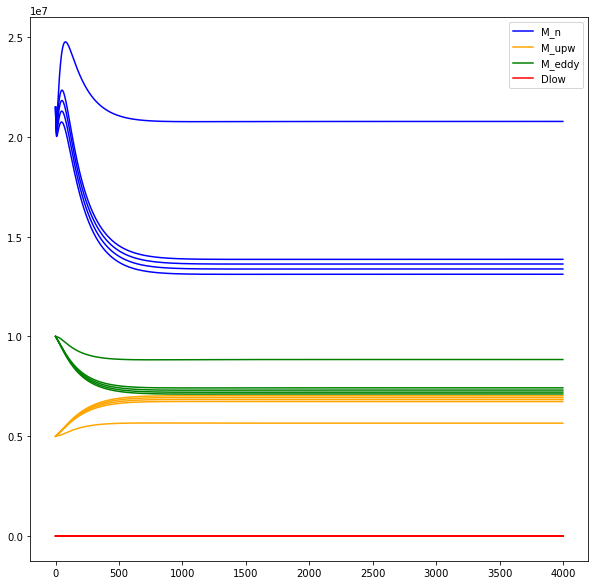

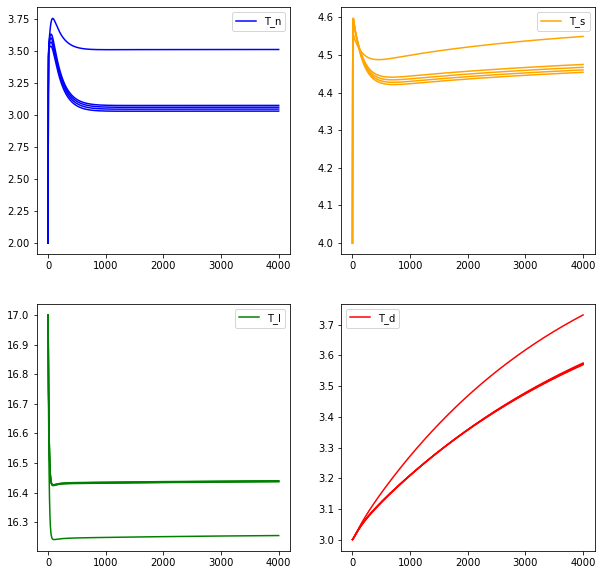

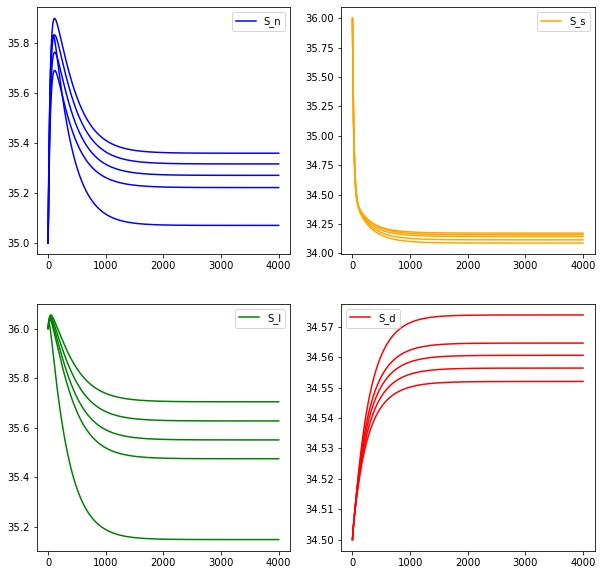

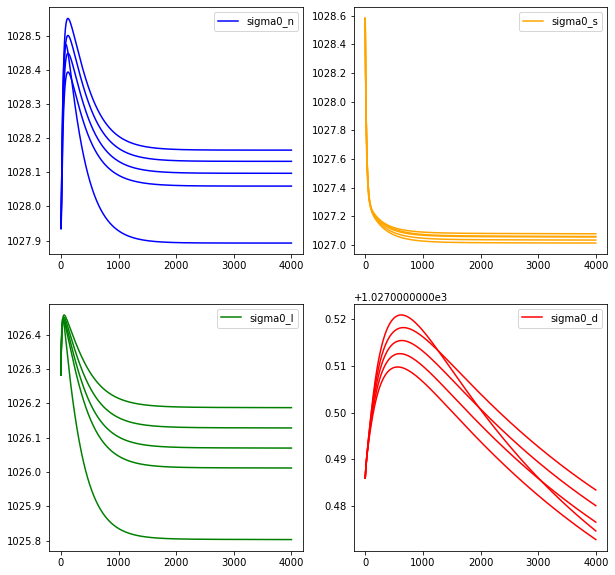

In [54]:
box_param_cols = [c for c in sim_1_df.columns if c not in ("mode_shift_detected", "grp_name")]

# Plot solutions
idxs = list(range(5))
fourbox_args = sim_1_df.loc[idxs, box_param_cols].to_dict("records")
run_simple_example(fourbox_args)

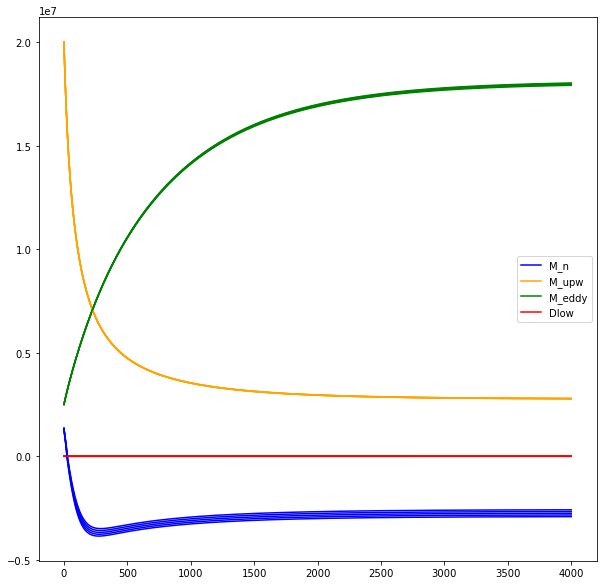

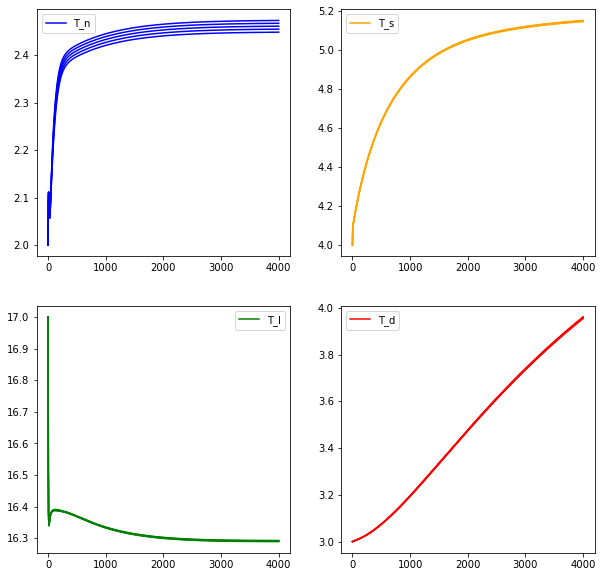

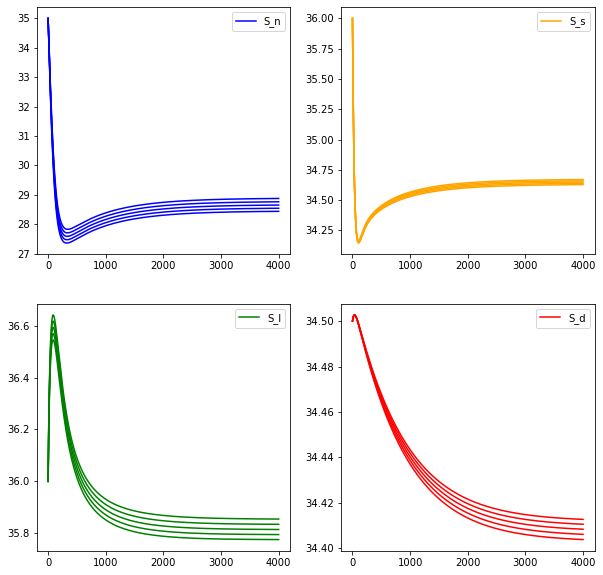

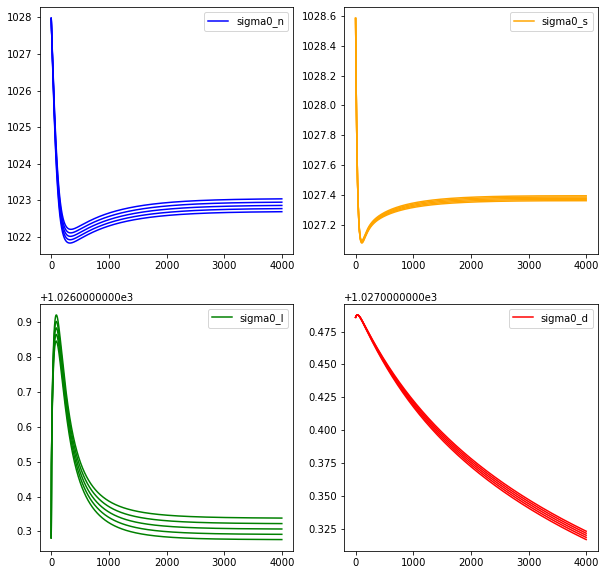

In [55]:
box_param_cols = [c for c in sim_1_df.columns if c not in ("mode_shift_detected", "grp_name")]

# Plot solutions
idxs = list(range(len(sim_1_df)-5, len(sim_1_df)))
fourbox_args = sim_1_df.loc[idxs, box_param_cols].to_dict("records")
run_simple_example(fourbox_args)

In [ ]:

# todo: make plots for real data (augmented)
# todo: count number of shutoffs vs. non-shutoffs